# **STEP 0: IMPORT LIBRARIES**

In [423]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  
from sklearn.preprocessing import OneHotEncoder      
from sklearn.model_selection import KFold   
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from statistics import mean
from sklearn.model_selection import train_test_split
import joblib 
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold

# Additional useful imports
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, median_absolute_error
import seaborn as sns
from scipy import stats
import warnings
import os
import yfinance as yf
import ta

# **STEP 1: DEFINE LABLE**

In [424]:
forex_label = ['GBPJPY=X'] # You can update by adding more

# **STEP 2: GET FOREX DATA CRAWLING**

**2.1: Crawl all FOREX data needed**

**2.1.1. Function to crawl Forex data**

In [425]:
def crawl_forex_data(forex_pair, directory='Dataset'):
    """
    Crawls historical data for a given Forex pair and saves it to a CSV file.

    Parameters:
    forex_pair (str): The Forex pair symbol to download data for (e.g., 'EURUSD=X').
    directory (str): The directory where the data should be saved.

    Returns:
    str: Path to the saved CSV file.
    pd.DataFrame: The crawled data as a Pandas DataFrame.
    """
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Download historical data for the Forex pair
    print(f"Downloading data for {forex_pair}...")
    data = yf.download(forex_pair, period="max", interval='1d')
    data.reset_index(inplace=True)  # Reset index to ensure 'Date' is a normal column

    # Save data to CSV
    file_path = os.path.join(directory, f'{forex_pair}_data.csv')
    data.to_csv(file_path, index=False)
    print(f"Saved data for {forex_pair} at {file_path}")

    return file_path, data

**2.2. Check crawling result**

In [426]:
file_path, data = crawl_forex_data(forex_label)
print(data.head(10))    

[*********************100%***********************]  1 of 1 completed

Saved data for ['GBPJPY=X'] at Dataset\['GBPJPY=X']_data.csv
        Date        Open        High         Low       Close   Adj Close  \
0 2003-12-01  189.330002  189.660004  187.740005  187.630005  187.630005   
1 2003-12-02  187.669998  188.809998  187.559998  188.009995  188.009995   
2 2003-12-03  188.020004  188.240005  186.490005  187.089996  187.089996   
3 2003-12-04  187.029999  187.029999  185.899994  186.220001  186.220001   
4 2003-12-05  186.190002  186.740005  185.830002  185.880005  185.880005   
5 2003-12-08  185.949997  186.699997  185.589996  186.179993  186.179993   
6 2003-12-09  186.179993  187.229996  185.809998  186.809998  186.809998   
7 2003-12-10  186.869995  189.160004  186.800003  188.509995  188.509995   
8 2003-12-11  188.589996  188.910004  188.050003  188.520004  188.520004   
9 2003-12-12  188.440002  188.860001  187.869995  188.059998  188.059998   

   Volume  
0       0  
1       0  
2       0  
3       0  
4       0  
5       0  
6       0  
7     

**STEP 3: FEATURE ENGINEERING**

In [427]:
# Feature Engineering
# Calculate moving averages
if 'Close' in data.columns:
    if len(data) >= 10: data['MA_10'] = data['Close'].rolling(window=10).mean()
    if len(data) >= 50: data['MA_50'] = data['Close'].rolling(window=50).mean()
    if len(data) >= 200: data['MA_200'] = data['Close'].rolling(window=200).mean()

# Calculate RSI
data['RSI'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()

# Calculate MACD
data['MACD'] = ta.trend.MACD(data['Close']).macd()

# Calculate Bollinger Bands
bollinger = ta.volatility.BollingerBands(data['Close'])
data['BB_High'] = bollinger.bollinger_hband()
data['BB_Low'] = bollinger.bollinger_lband()

# Calculate Bollinger BandWidth (BBTrend)
data['BB_Width'] = (data['BB_High'] - data['BB_Low']) / data['Close']

# 24-hour Volume
data['Volume_24h'] = data['Volume'].rolling(window=1440).sum()

# Accumulation/Distribution Line (ADL)
data['ADL'] = ta.volume.AccDistIndexIndicator(data['High'], data['Low'], data['Close'], data['Volume']).acc_dist_index()

# Aroon Indicator
aroon = ta.trend.AroonIndicator(data['Close'], data['Low'], window=25)
data['Aroon_Up'] = aroon.aroon_up()
data['Aroon_Down'] = aroon.aroon_down()


# Average Directional Index (ADX)
data['ADX'] = ta.trend.ADXIndicator(data['High'], data['Low'], data['Close'], window=14).adx()

# Average True Range (ATR)
data['ATR'] = ta.volatility.AverageTrueRange(data['High'], data['Low'], data['Close'], window=14).average_true_range()

# Awesome Oscillator (AO)
data['AO'] = ta.momentum.AwesomeOscillatorIndicator(data['High'], data['Low'], window1=5, window2=34).awesome_oscillator()

# Balance of Power (BOP)
data['BOP'] = (data['Close'] - data['Open']) / (data['High'] - data['Low'])

# Bull Bear Power
data['Bull_Power'] = data['High'] - data['MA_50']
data['Bear_Power'] = data['Low'] - data['MA_50']

# Chaikin Oscillator
data['Chaikin_Osc'] = data['ADL'].ewm(span=3).mean() - data['ADL'].ewm(span=10).mean()

# Stochastic Oscillator (Stoch)
stoch = ta.momentum.StochasticOscillator(data['High'], data['Low'], data['Close'], window=14)
data['Stoch_Osc'] = stoch.stoch()

# Commodity Channel Index (CCI)
data['CCI'] = ta.trend.CCIIndicator(data['High'], data['Low'], data['Close'], window=20).cci()

# Vortex Oscillator
vortex = ta.trend.VortexIndicator(data['High'], data['Low'], data['Close'], window=14)
data['Vortex_Plus'] = vortex.vortex_indicator_pos()
data['Vortex_Minus'] = vortex.vortex_indicator_neg()

# Examine the number of rows before dropping nan column
print("NaN values before dropping:", data.isna().sum())

# Drop rows with NaN values (due to moving averages and indicators)
data.dropna(subset=['Close', 'Open'], inplace=True)

# Try to fill missing data:
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

# Check how many rows remain after dropping NaN values
print(f"Number of rows after dropna: {len(data)}")


print(data.head(1000))


NaN values before dropping: Date               0
Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
MA_10              9
MA_50             49
MA_200           199
RSI               13
MACD              25
BB_High           19
BB_Low            19
BB_Width          19
Volume_24h      1439
ADL                0
Aroon_Up          25
Aroon_Down        25
ADX                0
ATR                0
AO                33
BOP               13
Bull_Power        49
Bear_Power        49
Chaikin_Osc        0
Stoch_Osc         13
CCI               19
Vortex_Plus       14
Vortex_Minus      14
dtype: int64
Number of rows after dropna: 5418
          Date        Open        High         Low       Close   Adj Close  \
0   2003-12-01  189.330002  189.660004  187.740005  187.630005  187.630005   
1   2003-12-02  187.669998  188.809998  187.559998  188.009995  188.009995   
2   2003-12-03  188.020004  188.240005  186.490005  187.08999

C:\Users\Admin\AppData\Local\Temp\ipykernel_20116\1676608491.py:72: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_20116\1676608491.py:73: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


In [428]:
# List of indicators to plot
indicators = [
    'MA_10', 'MA_50', 'MA_200',
    'RSI', 'MACD',
    'BB_High', 'BB_Low',
    'ADX', 'ATR', 'AO',
    'BOP', 'Bull_Power', 'Bear_Power',
    'Chaikin_Osc',
    'Stoch_Osc', 'CCI',
    'Vortex_Plus', 'Vortex_Minus'
    ]

# **STEP 4: SAVE NEW DATAFRAME**

In [429]:
path = os.path.join('Dataset', forex_label[0] + '_updated_data.csv')
print(f"Saving file to: {path}")  # Print the path for debugging
data.to_csv(path, index=False)

Saving file to: Dataset\GBPJPY=X_updated_data.csv


**STEP 5: PLOTTING FOR EVALUATION**

**Function to plot year data**

In [430]:
def plot_yearly_data(data, title='Yearly Price Data'):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

**Functions to plot prices vs indicators**

In [431]:
def plot_prices_vs_indicators(data, indicator, title):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')
    plt.plot(data['Date'], data[indicator], label=indicator, color='orange')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price / Indicator Value')
    plt.legend()
    plt.grid()
    plt.show()

**Function to plot out Label Price vs other forex pairs**

In [432]:
# **Function to plot out Label Price vs Other Forex Pairs**
def plot_label_vs_other_forex(data, label, other_pairs):
    plt.figure(figsize=(14, 7))
    
    # Check if the label exists in the DataFrame
    if label not in data.columns:
        print(f"Label '{label}' not found in DataFrame columns: {data.columns}")
        return

    plt.plot(data['Date'], data[label], label=label, color='blue')
    
    for pair in other_pairs:
        pair_close = f'{pair}_Close'
        if pair_close in data.columns:  # Ensure the pair exists in the DataFrame
            plt.plot(data['Date'], data[pair_close], label=f'{pair} Close', linestyle='--')
    
    plt.title(f'{label} vs Other Forex Pairs')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

**5.1. Plot out yearly data**

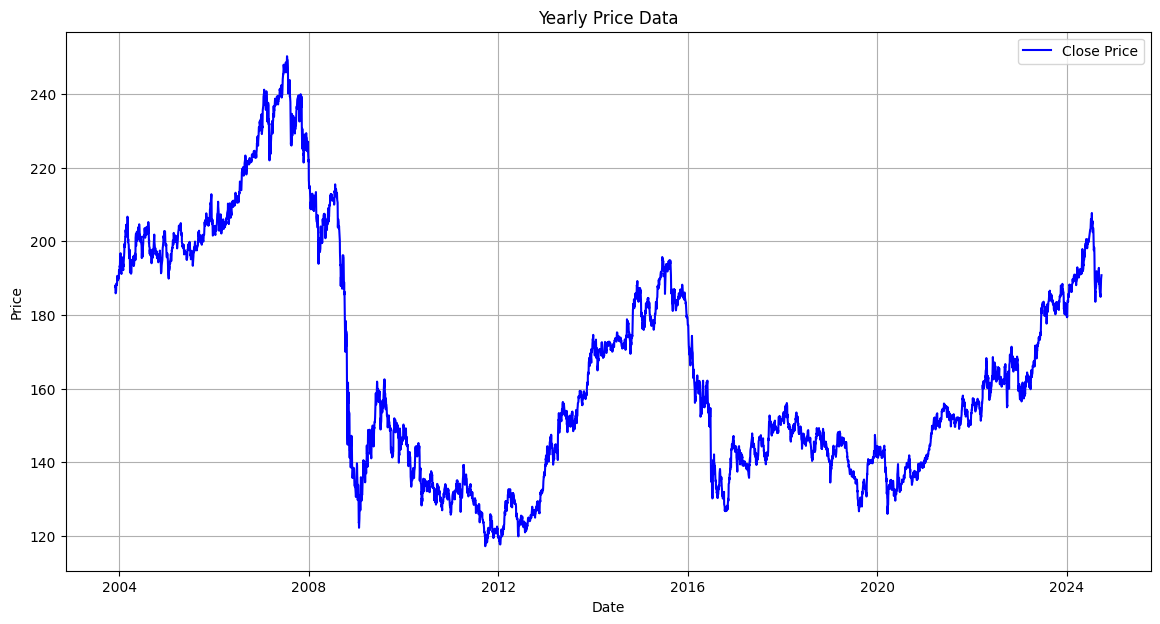

In [433]:
# Plot yearly data
plot_yearly_data(data)

**5.2. Plot out indicators vs price**

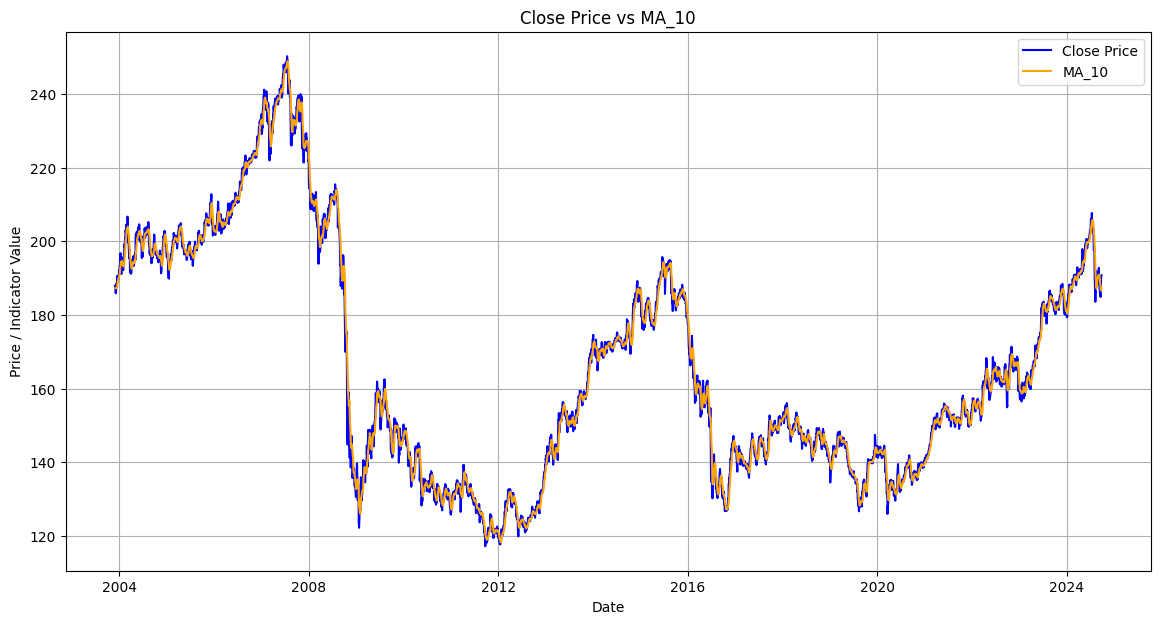

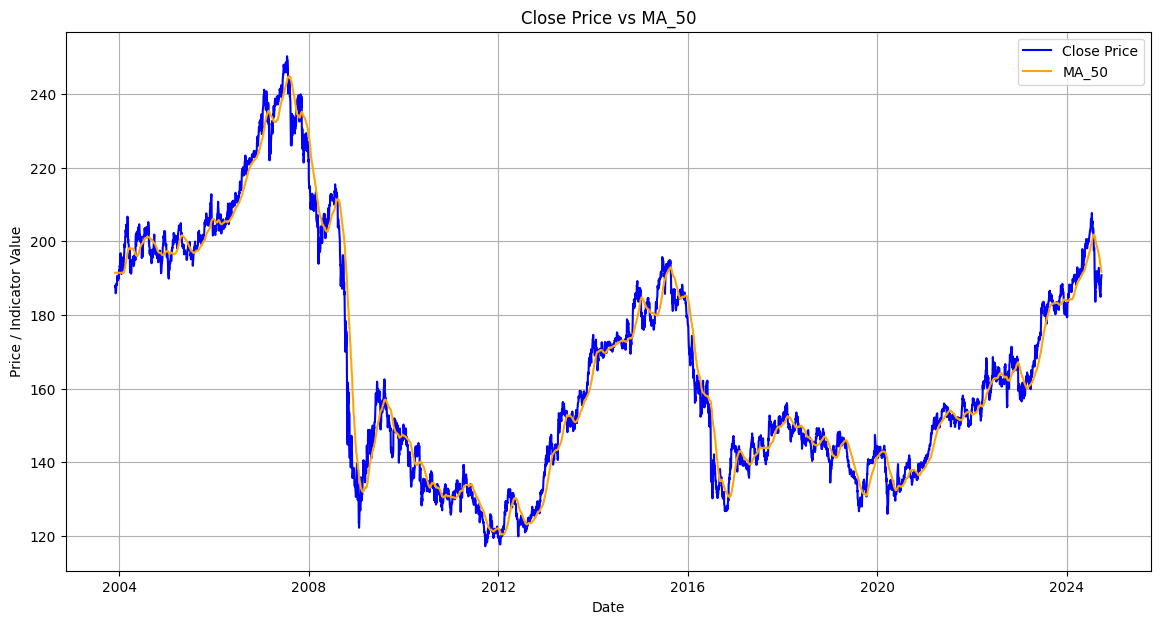

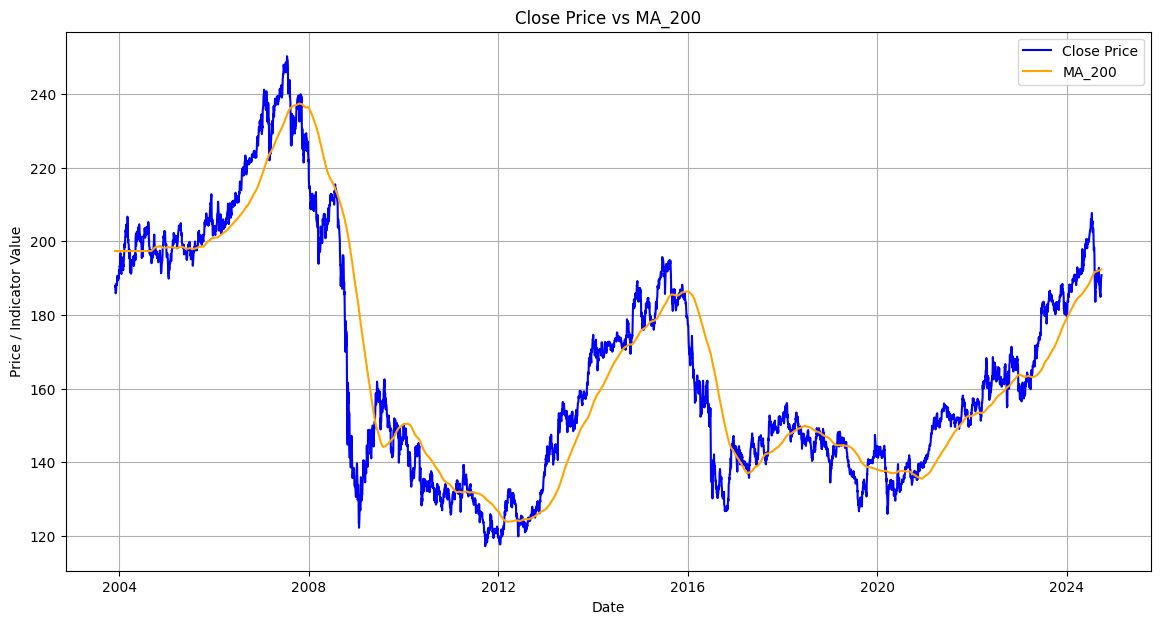

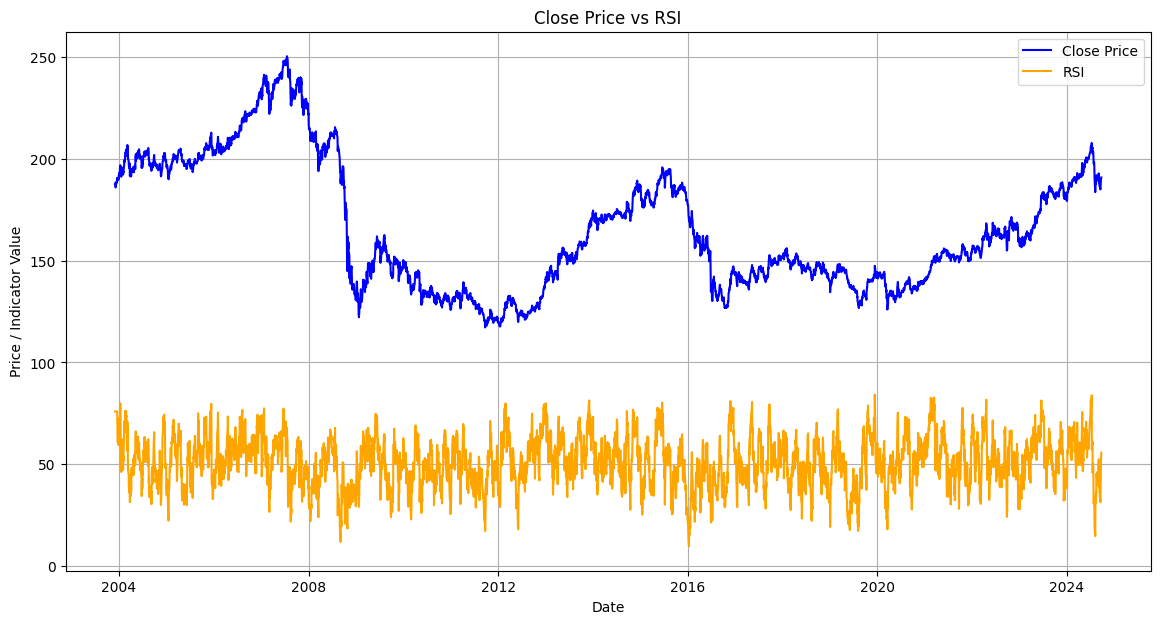

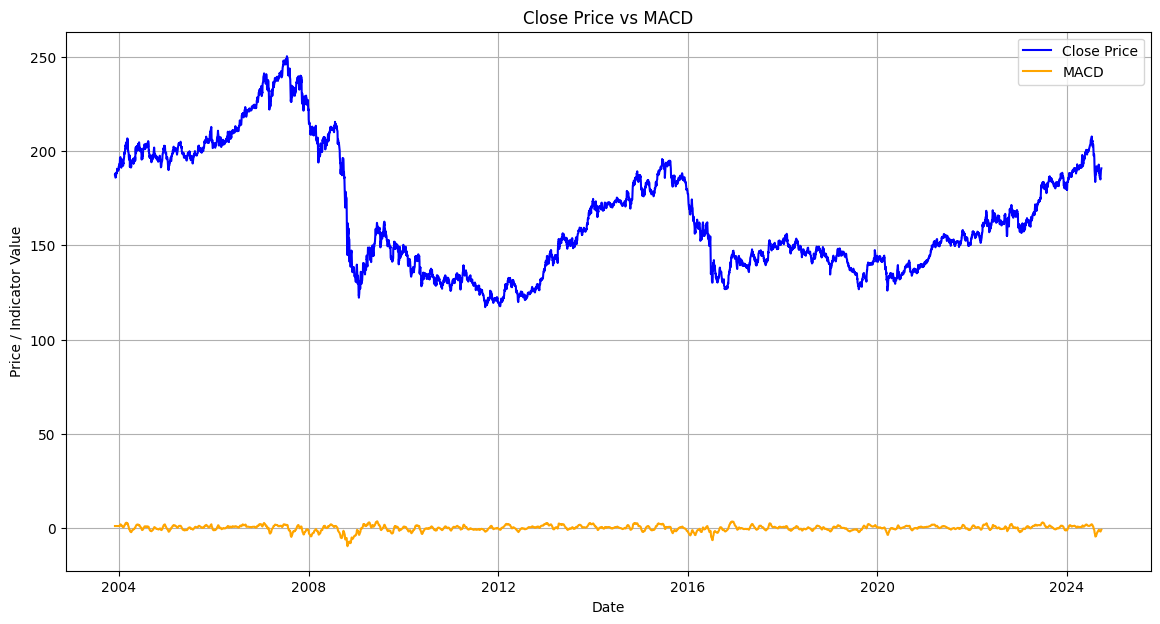

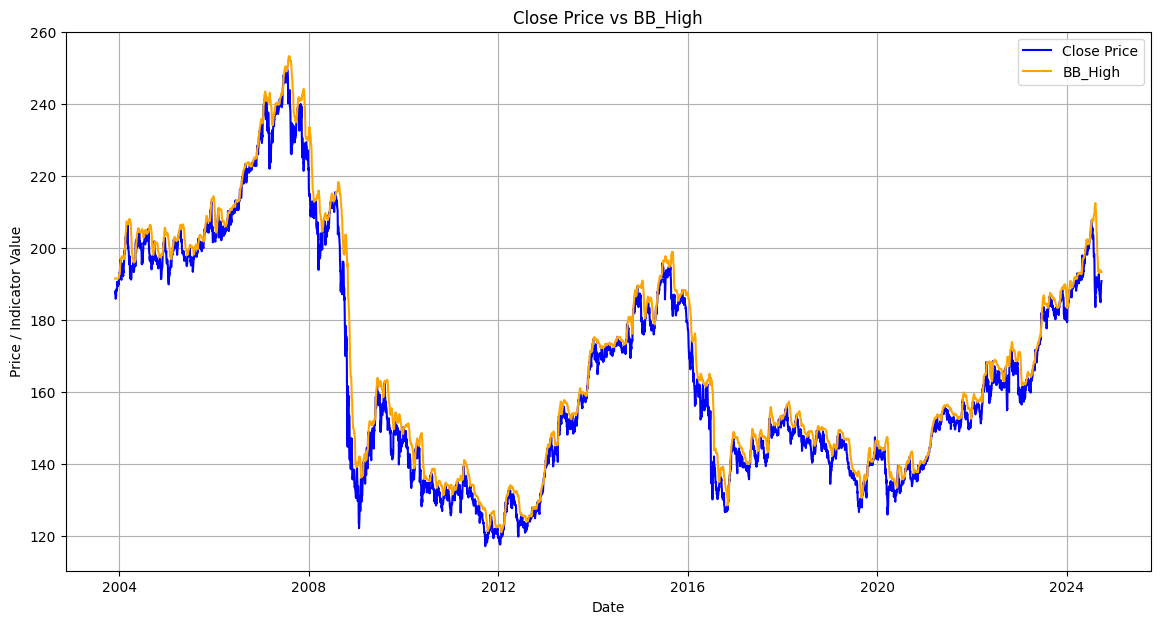

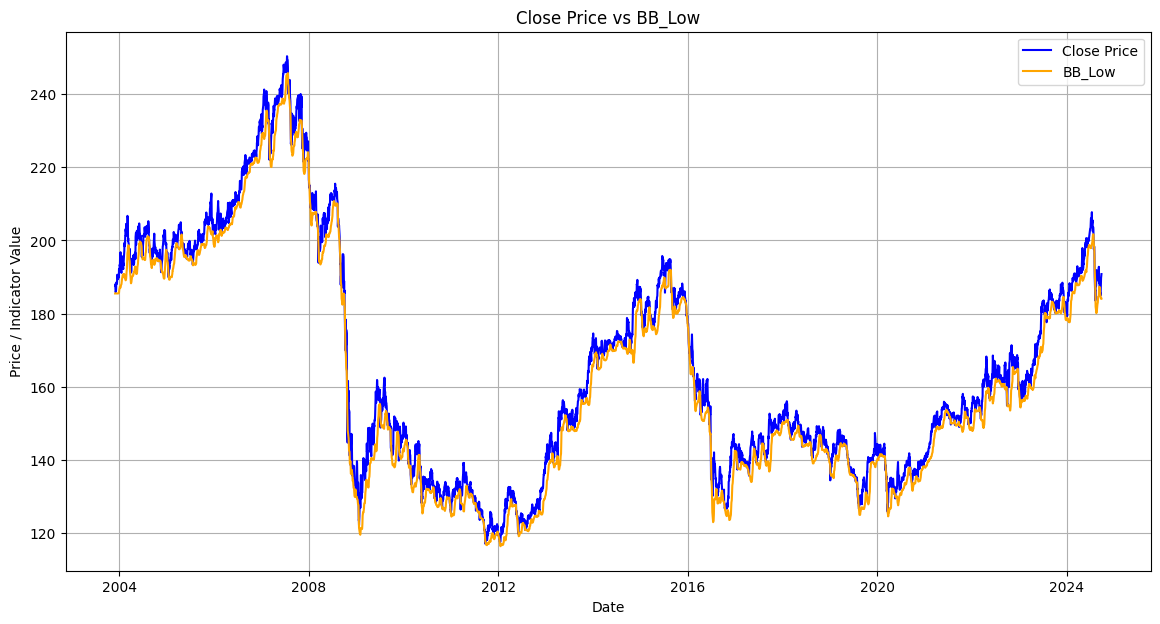

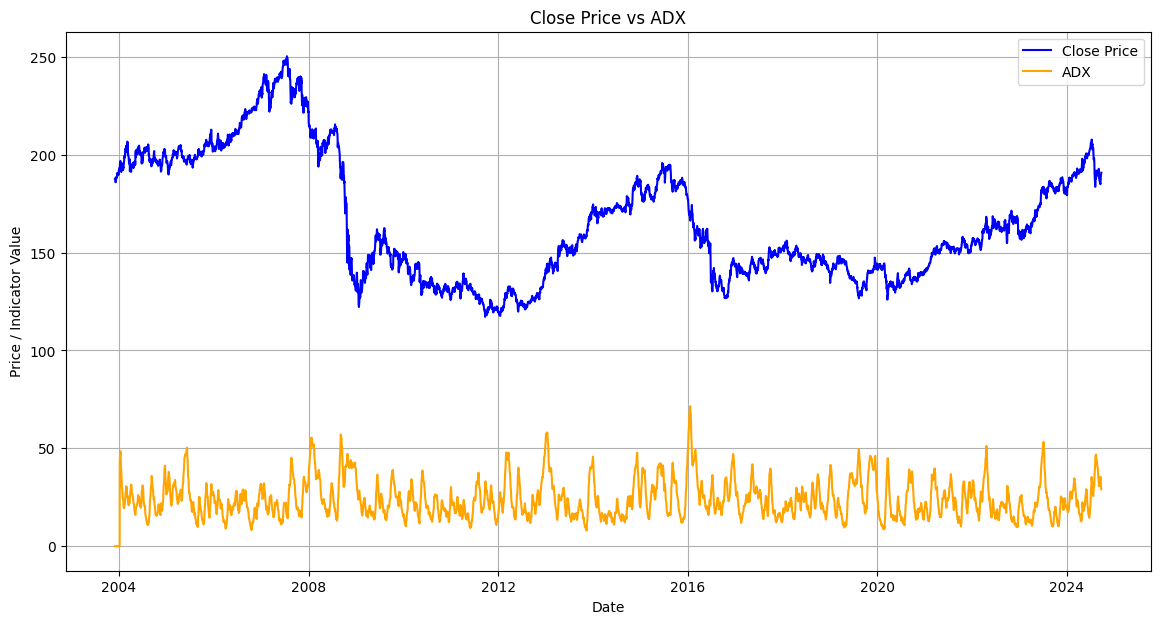

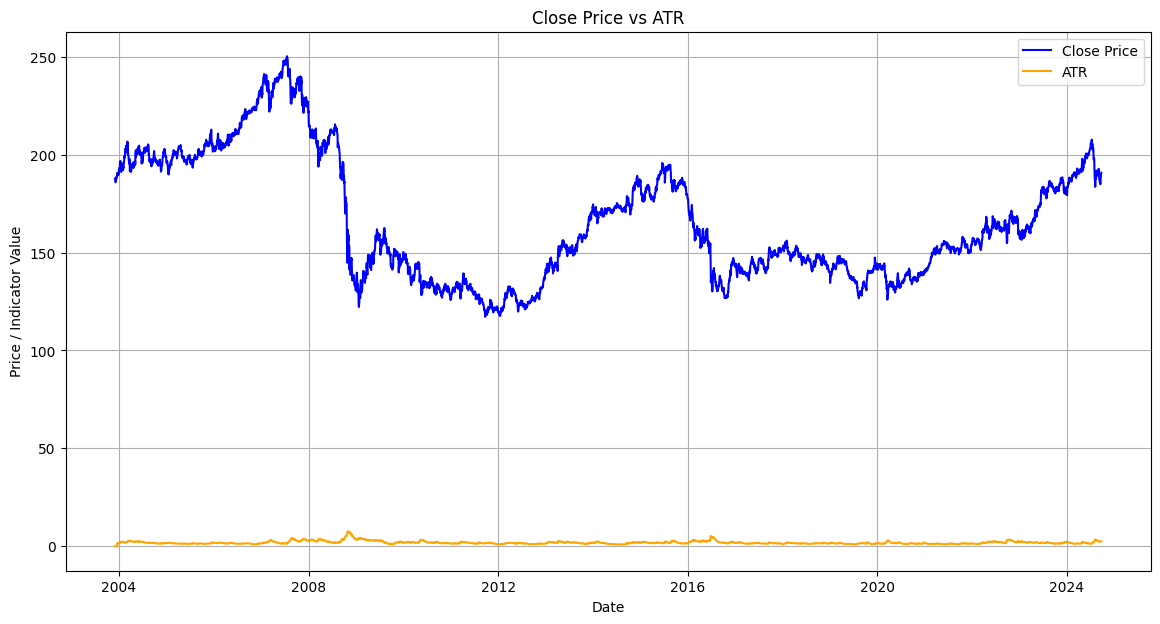

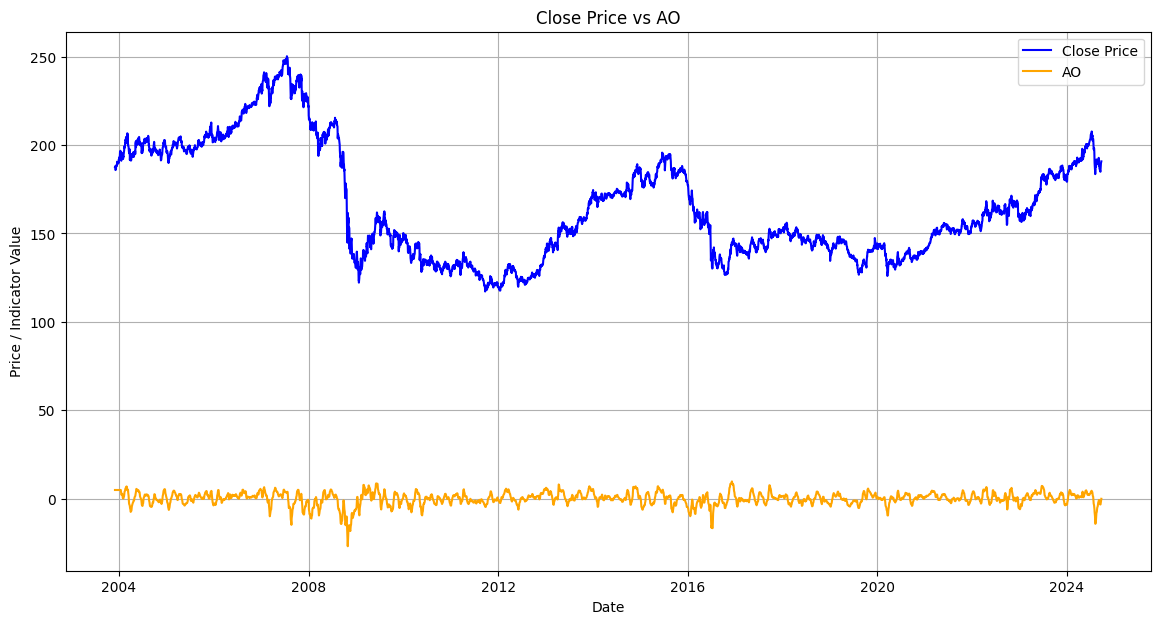

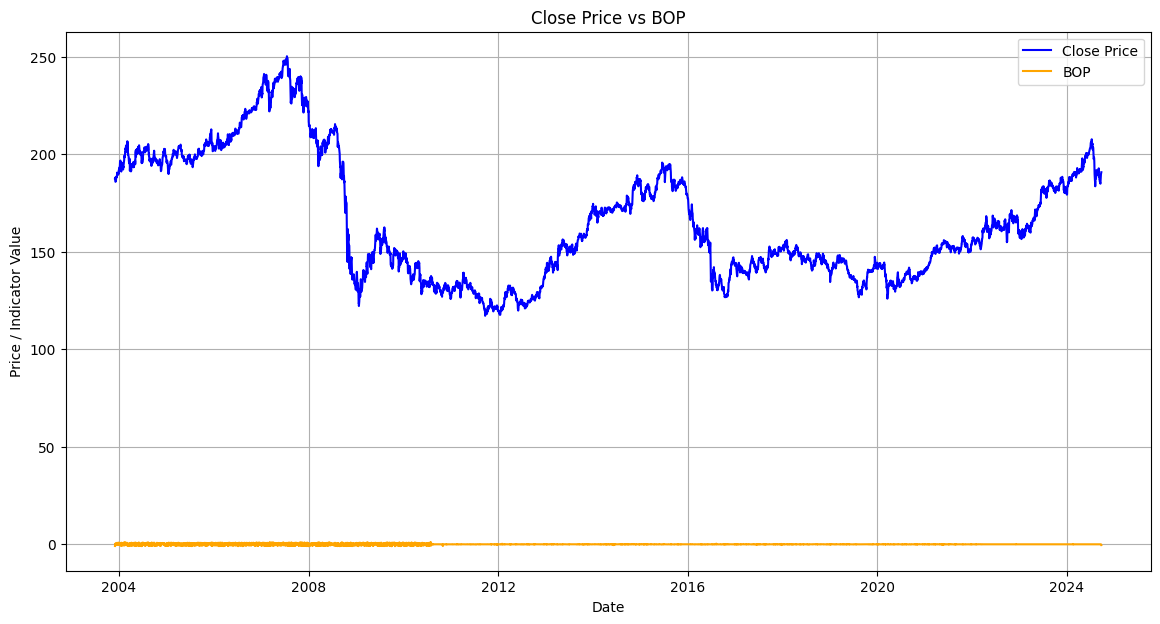

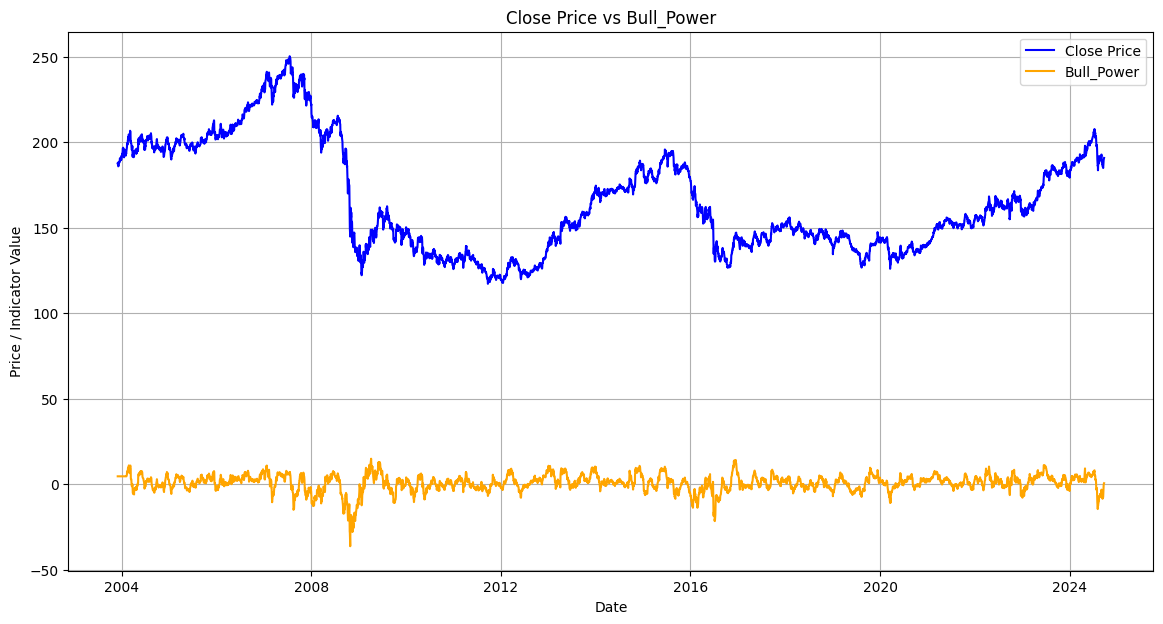

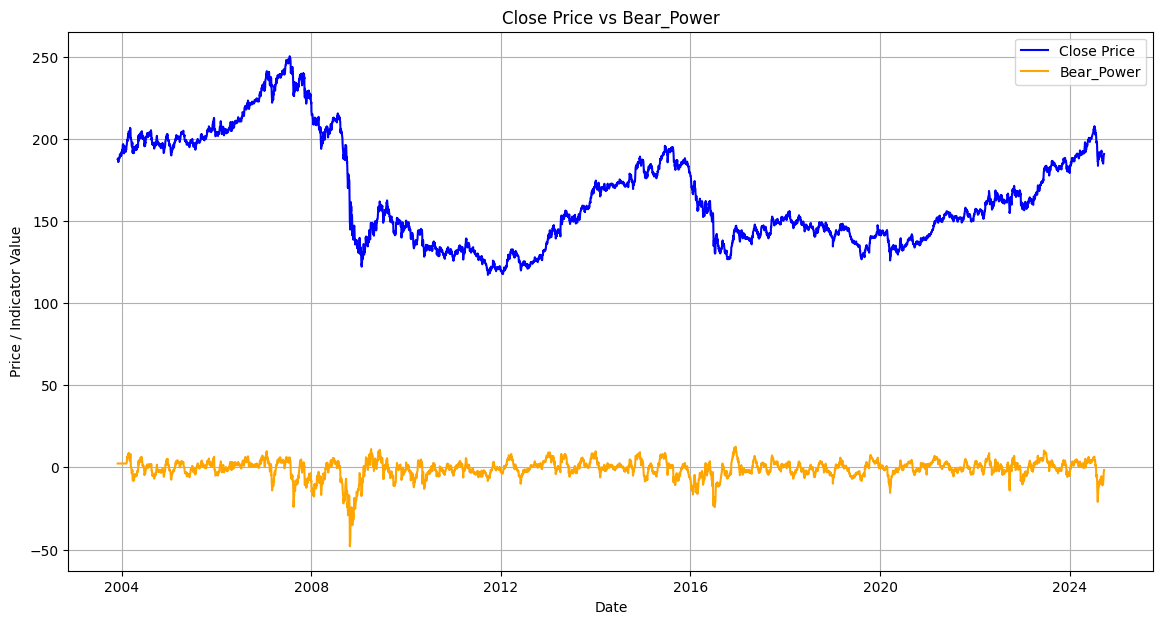

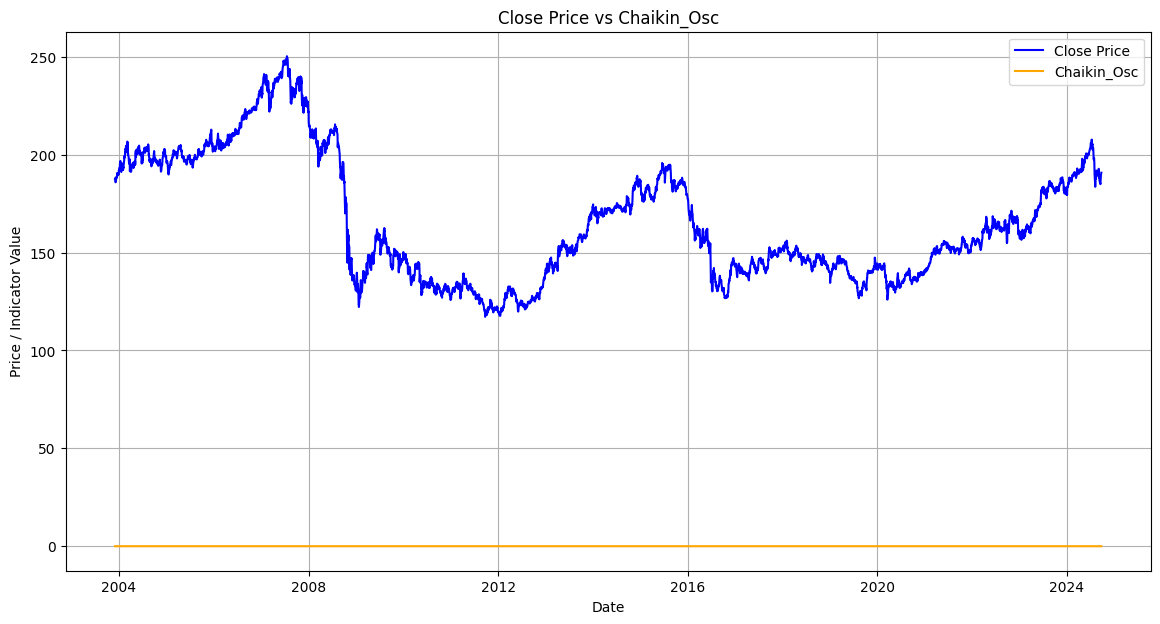

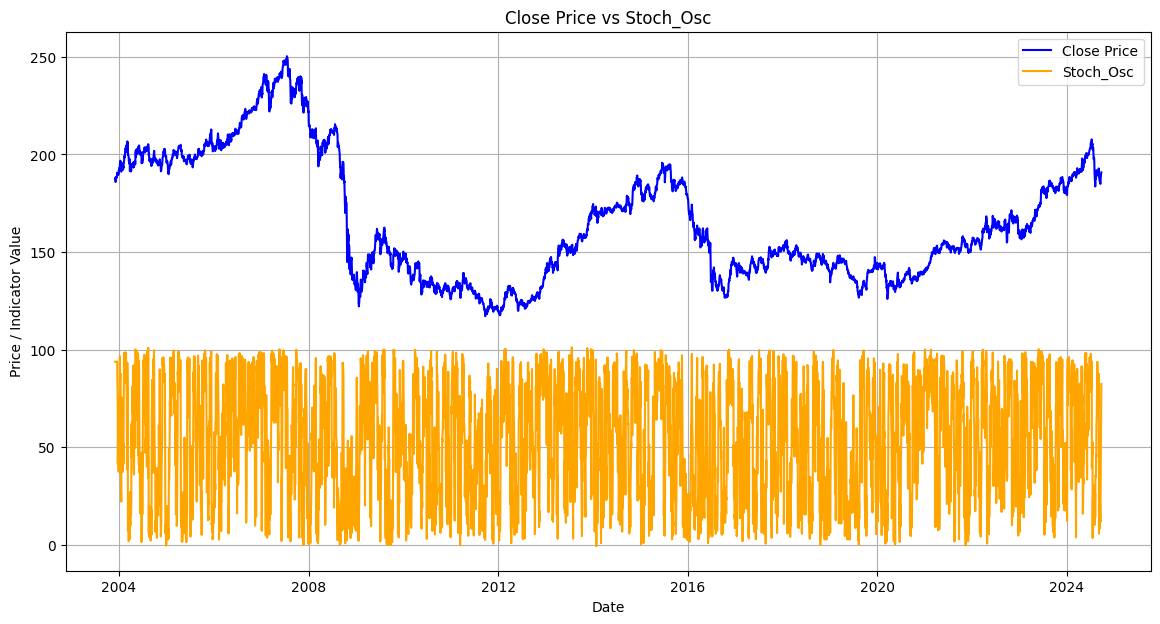

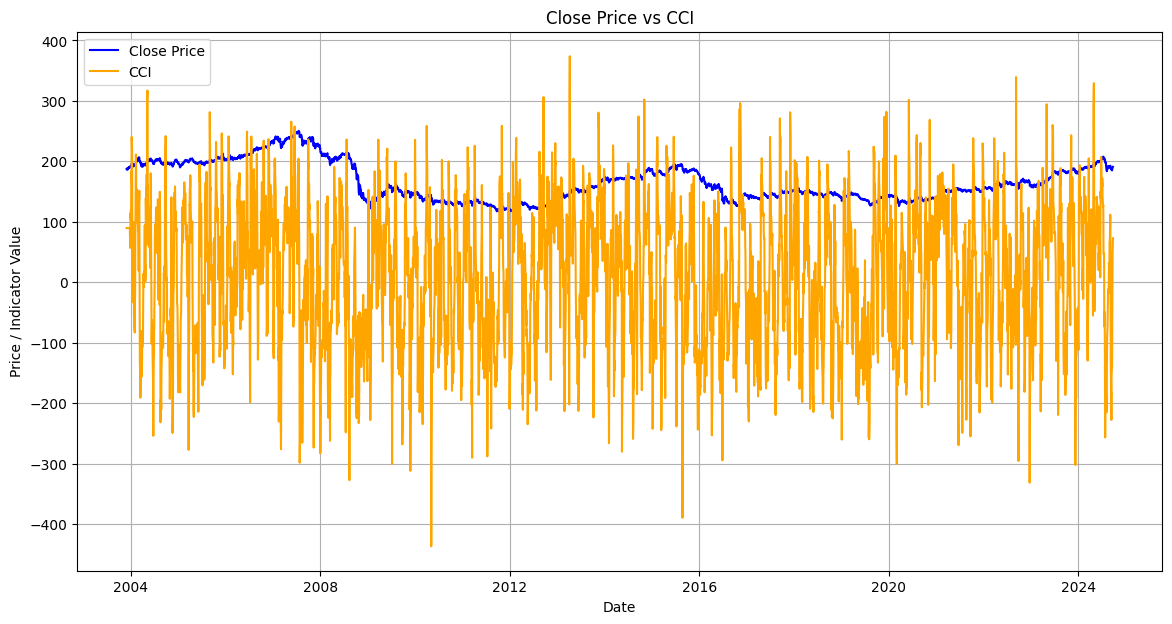

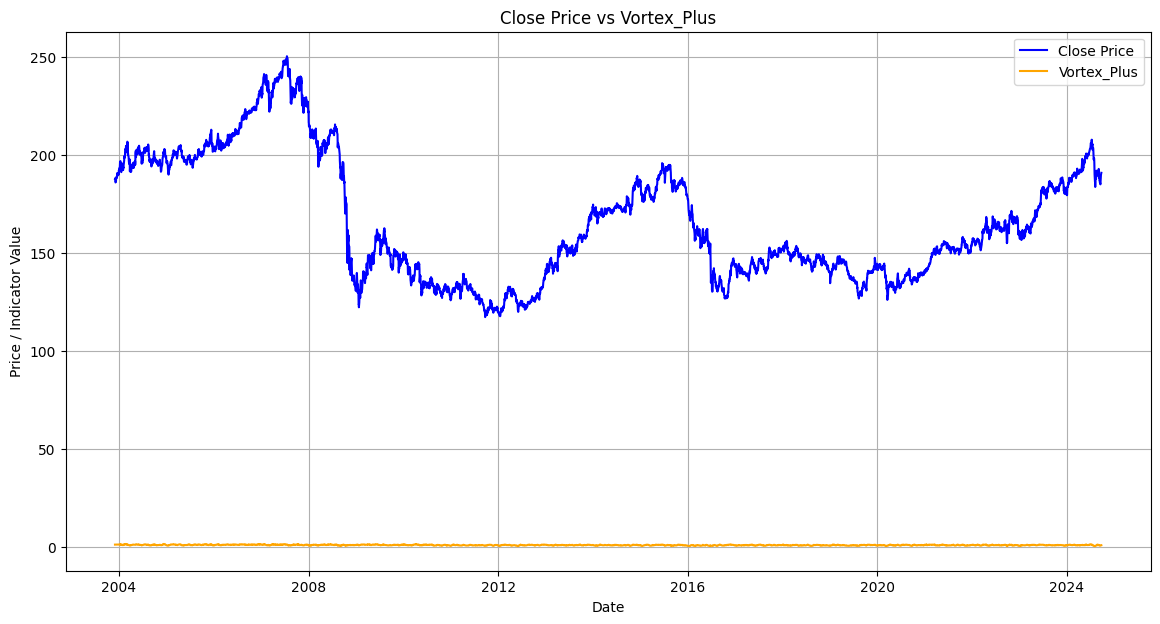

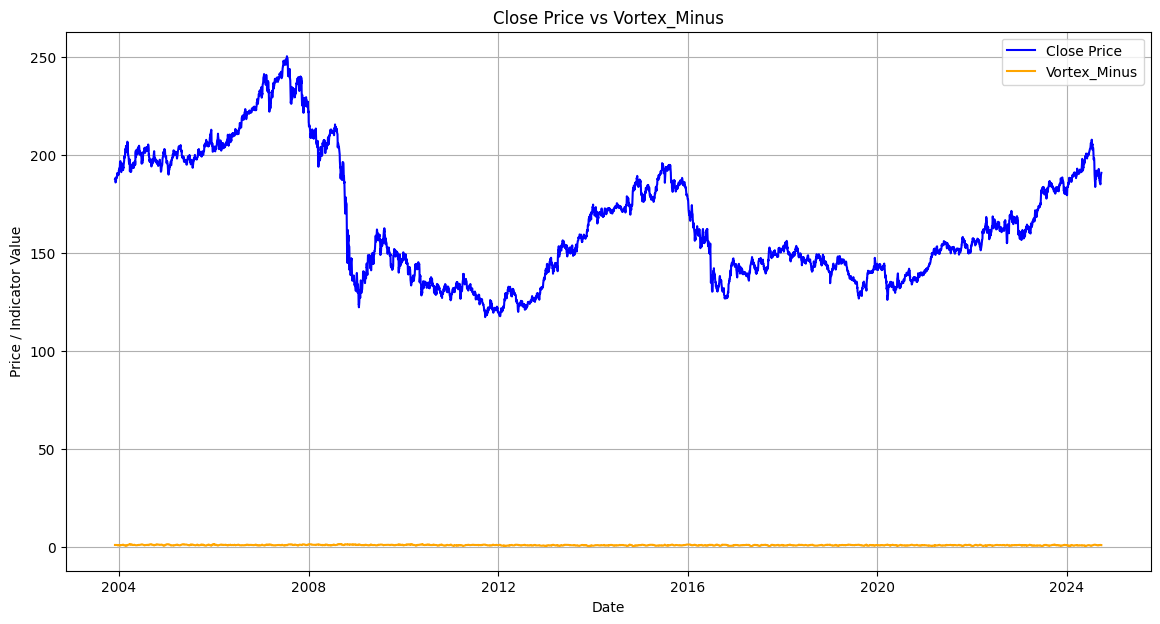

In [434]:
# Plot Close Price vs each indicator
for indicator in indicators:
    if indicator in data.columns:  # Check if the indicator exists
        plot_prices_vs_indicators(data, indicator, f'Close Price vs {indicator}')

# **STEP 6: FIND UN-RELATED FEATURES USING MUTUAL INFORMATION (MI)**

**6.0 Load New Data**

In [435]:
new_file_path = os.path.join('Dataset', forex_label[0] + '_updated_data.csv')
data = pd.read_csv(new_file_path)

6.1. Calculate MI and decide which feature has the highest correlation

In [436]:
# **6.1. Calculate MI and decide which feature has the highest correlation**
# Define the target variable
target = 'Close'  # You can update this to any other target variable

# Separate features and target
X = data.drop(columns=[target, 'Date'])  # Exclude the target and date columns
y = data[target]

# Calculate Mutual Information
mi_scores = mutual_info_regression(X, y)

# Create a DataFrame to hold MI scores
mi_df = pd.DataFrame(mi_scores, index=X.columns, columns=['MI Score']).sort_values(by='MI Score', ascending=False)

# Display the MI scores
print("Mutual Information Scores:")
print(mi_df)

# Identify features with the highest MI scores
top_features = mi_df[mi_df['MI Score'] > 0].index.tolist()
print(f"Top features with the highest MI scores: {top_features}")

Mutual Information Scores:
                  MI Score
Adj Close     7.316875e+00
Open          5.181621e+00
High          3.906410e+00
Low           3.814315e+00
MA_10         2.653347e+00
BB_Low        2.398974e+00
BB_High       2.368793e+00
MA_50         2.108279e+00
MA_200        2.075937e+00
ATR           4.189251e-01
BOP           3.884981e-01
MACD          3.861848e-01
Bull_Power    3.763634e-01
Bear_Power    3.288076e-01
BB_Width      3.169815e-01
AO            2.817523e-01
ADX           2.390854e-01
Vortex_Plus   2.277623e-01
RSI           2.098623e-01
Vortex_Minus  1.630377e-01
CCI           1.047273e-01
Stoch_Osc     1.011431e-01
Aroon_Up      1.455662e-02
Aroon_Down    1.215070e-02
Volume_24h    2.535236e-05
ADL           2.463985e-05
Chaikin_Osc   8.249867e-07
Volume        0.000000e+00
Top features with the highest MI scores: ['Adj Close', 'Open', 'High', 'Low', 'MA_10', 'BB_Low', 'BB_High', 'MA_50', 'MA_200', 'ATR', 'BOP', 'MACD', 'Bull_Power', 'Bear_Power', 'BB_Width', '

**6.2. Drop unrelated features**

In [437]:
# Define a threshold for MI score
mi_threshold = 0.25

# Identify features to drop based on the MI score
features_to_drop = mi_df[mi_df['MI Score'] < mi_threshold].index.tolist()

# Drop the unrelated features from the DataFrame
X_reduced = X.drop(columns=features_to_drop)

# Optionally, you can also update the DataFrame with the target
data_reduced = data.drop(columns=features_to_drop)

# Check the remaining features
print("Remaining features after dropping unrelated ones:")
print(X_reduced.columns)

# Save the reduced DataFrame if needed
reduced_file_path = os.path.join('Dataset', forex_label[0] + '_reduced_data.csv')
data_reduced.to_csv(reduced_file_path, index=False)
print(f"Saved reduced data to: {reduced_file_path}")
print(data.head(1000))

Remaining features after dropping unrelated ones:
Index(['Open', 'High', 'Low', 'Adj Close', 'MA_10', 'MA_50', 'MA_200', 'MACD',
       'BB_High', 'BB_Low', 'BB_Width', 'ATR', 'AO', 'BOP', 'Bull_Power',
       'Bear_Power'],
      dtype='object')
Saved reduced data to: Dataset\GBPJPY=X_reduced_data.csv
           Date        Open        High         Low       Close   Adj Close  \
0    2003-12-01  189.330002  189.660004  187.740005  187.630005  187.630005   
1    2003-12-02  187.669998  188.809998  187.559998  188.009995  188.009995   
2    2003-12-03  188.020004  188.240005  186.490005  187.089996  187.089996   
3    2003-12-04  187.029999  187.029999  185.899994  186.220001  186.220001   
4    2003-12-05  186.190002  186.740005  185.830002  185.880005  185.880005   
..          ...         ...         ...         ...         ...         ...   
995  2007-09-27  232.669998  234.449997  232.449997  234.130005  234.130005   
996  2007-09-28  234.080002  235.240005  232.479996  235.240005 

# **STEP 7: PRE-PROCESS DATA**

**7.1. Shift Label**

In [438]:
k = -3
data['Close'] = data['Close'].shift(k)

#   Drop the rows with NaN values that were created by the shift
data = data.dropna()

print(data.head(1000))

           Date        Open        High         Low       Close   Adj Close  \
0    2003-12-01  189.330002  189.660004  187.740005  186.220001  187.630005   
1    2003-12-02  187.669998  188.809998  187.559998  185.880005  188.009995   
2    2003-12-03  188.020004  188.240005  186.490005  186.179993  187.089996   
3    2003-12-04  187.029999  187.029999  185.899994  186.809998  186.220001   
4    2003-12-05  186.190002  186.740005  185.830002  188.509995  185.880005   
..          ...         ...         ...         ...         ...         ...   
995  2007-09-27  232.669998  234.449997  232.449997  236.020004  234.130005   
996  2007-09-28  234.080002  235.240005  232.479996  236.919998  235.240005   
997  2007-10-01  234.899994  236.979996  234.720001  237.320007  236.679993   
998  2007-10-02  236.660004  236.720001  234.949997  238.479996  236.020004   
999  2007-10-03  236.000000  237.839996  235.899994  238.759995  236.919998   

     Volume       MA_10      MA_50     MA_200  ... 

**7.2. Split-training the data set**

In [439]:
# Split the data into training and test sets
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)  

# Print out some information of the split of the training set and the test set
print('\n____________ Split training and test set ____________')     
print(len(train_set), "training +", len(test_set), "test examples")
print(train_set.head(4))


____________ Split training and test set ____________
4332 training + 1083 test examples
            Date        Open        High         Low       Close   Adj Close  \
1323  2009-01-07  139.194000  141.380005  138.009995  132.492004  139.718994   
1583  2010-01-06  146.410004  148.419998  145.988998  148.350006  147.929993   
2053  2011-10-27  121.566002  121.952003  121.099998  125.889000  121.550003   
2879  2014-12-29  187.270004  187.748001  187.119995  186.429993  187.250000   

      Volume       MA_10       MA_50      MA_200  ...       ATR        AO  \
1323       0  134.215399  141.435939  185.298574  ...  3.581539 -1.608862   
1583       0  147.695900  147.112720  150.398955  ...  1.943872  2.960142   
2053       0  121.373100  121.859820  129.088910  ...  1.492787  1.213235   
2879       0  186.177199  182.941000  175.254990  ...  1.703583  1.471058   

           BOP  Bull_Power  Bear_Power  Chaikin_Osc  Stoch_Osc         CCI  \
1323  0.155784   -0.055934   -3.425944       

**7.3. Separate labels from data**

In [440]:
# Separate labels from data
X_train = train_set.drop(columns=['Close'])
y_train = train_set['Close']
X_test = test_set.drop(columns=['Close'])
y_test = test_set['Close']

**7.4. Define pipeline for processing data**

In [441]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    # Constructor takes a list of column names to select
    def __init__(self, feature_names):
        self.feature_names = feature_names  # Store the list of column names

    # The fit method doesn't need to do anything, it just returns self
    # to be compatible with scikit-learn's pipeline process
    def fit(self, dataframe, labels=None):
        return self

    # The transform method selects columns from the DataFrame based on the list of column names
    # and returns the values as a NumPy array
    def transform(self, dataframe):
        return dataframe[self.feature_names].values  # Select and return columns as a NumPy array


In [442]:
num_feat_names = num_feat_names = X_train.select_dtypes(include=[np.number]).columns.tolist()
print(num_feat_names)

['Open', 'High', 'Low', 'Adj Close', 'Volume', 'MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'BB_High', 'BB_Low', 'BB_Width', 'Volume_24h', 'ADL', 'Aroon_Up', 'Aroon_Down', 'ADX', 'ATR', 'AO', 'BOP', 'Bull_Power', 'Bear_Power', 'Chaikin_Osc', 'Stoch_Osc', 'CCI', 'Vortex_Plus', 'Vortex_Minus']


**7.4.1 Pipeline for numerical features**

In [443]:
# Define numerical preprocessing steps
num_pipeline = Pipeline(steps=[
    ('selector', ColumnSelector(num_feat_names)),  # Select numerical features
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),    # Impute missing values
    ('scaler', StandardScaler(with_mean=True, with_std=True))                     # Scale the features
])

**7.4.2. Run the pipeline to process training data**

In [444]:
processed_train_set_val = num_pipeline.fit_transform(train_set)

# Fit the pipeline on training data and transform both training and test data
X_train = num_pipeline.fit_transform(X_train)
X_test = num_pipeline.transform(X_test)
X_train = pd.DataFrame(X_train, columns=num_feat_names)
X_test = pd.DataFrame(X_test, columns=num_feat_names)


print('\n____________ Processed feature values ____________')
print(processed_train_set_val[:3, :]) # Print out some of the first rows of the training dataset after fit_transforming
print(processed_train_set_val.shape)  # Print out the statistics of the training set
joblib.dump(num_pipeline, r'models/num_pipeline.pkl')   #  Save the pipeline 


____________ Processed feature values ____________
[[-0.85571075 -0.80702075 -0.86999788 -0.83821435  0.         -1.01729845
  -0.7902616   0.64873305  0.41754302 -1.0533189  -0.93964255 -1.05438048
   0.91875633  0.          0.          1.31440485  0.88044922  0.7634947
   2.30573968 -0.44507787  0.47270673 -0.16582931 -0.49301533  0.
   1.07200867  1.28027695  1.26112344  0.35908845]
 [-0.62299568 -0.58061781 -0.61191377 -0.57351786  0.         -0.58182778
  -0.60582724 -0.51355343  0.13914521  0.39343068 -0.62313491 -0.60929129
  -0.03007133  0.          0.          0.98313996 -0.69358345 -0.92877746
   0.14190758  0.8171181   2.02436856  0.1147016  -0.05747574  0.
   0.02472672  0.34209967  1.00716699  0.44360744]
 [-1.42421113 -1.43181633 -1.41695855 -1.42392487  0.         -1.43215283
  -1.42627501 -1.22325679  0.1586284   0.08643609 -1.49135758 -1.43235318
  -0.21401982  0.          0.          0.43103181 -0.13142893 -0.54840477
  -0.45410759  0.33453183 -0.1042458  -0.13534873

['models/num_pipeline.pkl']

# **STEP 8: Train and evaluate Model**

**Function to calculate R2 score and Root Mean Squared Error.**

In [445]:
def r2score_and_rmse(model, train_data, labels): 
    r2score = model.score(train_data, labels)
    from sklearn.metrics import mean_squared_error
    prediction = model.predict(train_data)
    mse = mean_squared_error(labels, prediction)
    rmse = np.sqrt(mse)
    return r2score, rmse

**Function to Store and Load Models.**

In [446]:
def store_model(model, model_name = ""):
    # NOTE: sklearn.joblib faster than pickle of Python
    # INFO: can store only ONE object in a file
    if model_name == "": 
        model_name = type(model).__name__
    joblib.dump(model,'models/' + model_name + '_model.pkl')
    print(f"Model successfully saved as " + model_name + '_model.pkl')
    
def load_model(model_name):
    # Load objects into memory
    #del model
    model = joblib.load('models/' + model_name + '_model.pkl')
    #print(model)
    return model

## **5.1. Try Light GBM model.**

In [447]:
model = lgb.LGBMRegressor() #fix here
model.fit(X_train, y_train)

print('\n____________ LGBMRegressor ____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)


# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:9]))
print("Labels:      ", list(y_test[:9]))

store_model(model)


____________ LGBMRegressor ____________

R2 score (on training data, best=1): 0.9986006805012865
Root Mean Square Error:  1.1594298999672454

Predictions:  [193.93831752 134.70680534 142.19121768 133.17459356 210.74021583
 192.53814533 201.85905953 193.1832099  131.72215353]
Labels:       [190.9199981689453, 136.74400329589844, 142.69000244140625, 133.65899658203125, 208.8370056152344, 191.2449951171875, 200.9499969482422, 192.72000122070312, 133.64999389648438]
Model successfully saved as LGBMRegressor_model.pkl


## **5.2. Try XGBoost model.**

In [448]:
model = XGBRegressor() #fix here
model.fit(X_train, y_train)

print('\n____________ XGBoost_Regressor ____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)


# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:9]))
print("Labels:      ", list(y_test[:9]))

store_model(model)


____________ XGBoost_Regressor ____________

R2 score (on training data, best=1): 0.9997765001199144
Root Mean Square Error:  0.4633665724415198

Predictions:  [193.95198 134.02481 142.39178 133.98763 209.61879 191.65103 200.4466
 191.78165 132.61237]
Labels:       [190.9199981689453, 136.74400329589844, 142.69000244140625, 133.65899658203125, 208.8370056152344, 191.2449951171875, 200.9499969482422, 192.72000122070312, 133.64999389648438]
Model successfully saved as XGBRegressor_model.pkl


## **5.3. Try Decision Tree (in-lecture).**

In [449]:
model = DecisionTreeRegressor() #fix here
model.fit(X_train, y_train)

print('\n____________DecisionTreeRegressor____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# 

# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:9]))
print("Labels:      ", list(y_test[:9]))

store_model(model)


____________DecisionTreeRegressor____________

R2 score (on training data, best=1): 1.0
Root Mean Square Error:  0.0

Predictions:  [195.6499939  134.25900269 141.75999451 133.49899292 208.86999512
 193.71699524 198.5        191.21000671 131.90800476]
Labels:       [190.9199981689453, 136.74400329589844, 142.69000244140625, 133.65899658203125, 208.8370056152344, 191.2449951171875, 200.9499969482422, 192.72000122070312, 133.64999389648438]
Model successfully saved as DecisionTreeRegressor_model.pkl


## **5.4. Try Polynomial Regression (in-lecture).**

In [450]:
# Sử dụng PolynomialFeatures kết hợp với một mô hình hồi quy
degree = 2  # Độ của đa thức bạn muốn tạo
model = Pipeline([
    ('poly_features', PolynomialFeatures(degree=degree)),
    ('lin_reg', LinearRegression())
])

model.fit(X_train, y_train)

print('\n____________PolynomialRegressor____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
print("Labels:      ", list(y_test[:9]))

store_model(model)


____________PolynomialRegressor____________

R2 score (on training data, best=1): 0.9966107140165592
Root Mean Square Error:  1.8044305065050086

Predictions:  [193.2 134.9 141.9 134.7 208.7 191.  202.8 193.1 132.4]
Labels:       [190.9199981689453, 136.74400329589844, 142.69000244140625, 133.65899658203125, 208.8370056152344, 191.2449951171875, 200.9499969482422, 192.72000122070312, 133.64999389648438]
Model successfully saved as Pipeline_model.pkl


## **5.5. Try Linear Regressor (in-lecture).**

In [451]:
model = LinearRegression() #fix here
model.fit(X_train, y_train)

print('\n____________LinearRegressor____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# 

# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
print("Labels:      ", list(y_test[:9]))

store_model(model)


____________LinearRegressor____________

R2 score (on training data, best=1): 0.9954672325833205
Root Mean Square Error:  2.086737260068854

Predictions:  [193.8 134.9 142.3 133.6 209.6 192.8 203.7 192.4 131.4]
Labels:       [190.9199981689453, 136.74400329589844, 142.69000244140625, 133.65899658203125, 208.8370056152344, 191.2449951171875, 200.9499969482422, 192.72000122070312, 133.64999389648438]
Model successfully saved as LinearRegression_model.pkl


## **5.6. Try Random Forest (in-lecture).**

In [452]:
model = RandomForestRegressor(n_estimators = 5)
model.fit(X_train, y_train)

print('\n____________RandomForestRegressor____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)



# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
print("Labels:      ", list(y_test[:9]))

store_model(model)


____________RandomForestRegressor____________

R2 score (on training data, best=1): 0.9991084934937147
Root Mean Square Error:  0.9254400951521375

Predictions:  [194.5 134.4 142.4 135.4 211.1 192.5 204.5 191.8 131.8]
Labels:       [190.9199981689453, 136.74400329589844, 142.69000244140625, 133.65899658203125, 208.8370056152344, 191.2449951171875, 200.9499969482422, 192.72000122070312, 133.64999389648438]
Model successfully saved as RandomForestRegressor_model.pkl


## **5.7. Try K-Nearest-Neighbor**

In [453]:
model = KNeighborsRegressor(n_neighbors=5)  # fix here
model.fit(X_train, y_train)

print('\n____________KNeighborsRegressor____________')

# Tính toán r2 score và rmse
r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# Dự đoán nhãn cho một số mẫu thử nghiệm
print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
print("Labels:      ", list(y_test[:9]))

# Lưu mô hình đã huấn luyện
store_model(model)


____________KNeighborsRegressor____________

R2 score (on training data, best=1): 0.9949920502833254
Root Mean Square Error:  2.1933908775423254

Predictions:  [195.4 135.1 143.8 134.9 210.6 189.2 194.7 196.  131.6]
Labels:       [190.9199981689453, 136.74400329589844, 142.69000244140625, 133.65899658203125, 208.8370056152344, 191.2449951171875, 200.9499969482422, 192.72000122070312, 133.64999389648438]
Model successfully saved as KNeighborsRegressor_model.pkl


## **5.8. Try using SVR**

In [454]:
model = SVR(kernel='rbf')  # fix here, với kernel 'rbf' mặc định
model.fit(X_train, y_train)

print('\n____________Support Vector Regressor (SVR)____________')

# Tính toán r2 score và rmse
r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# Dự đoán nhãn cho một số mẫu thử nghiệm
print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
print("Labels:      ", list(y_test[:9]))

# Lưu mô hình đã huấn luyện
store_model(model)



____________Support Vector Regressor (SVR)____________

R2 score (on training data, best=1): 0.9843604385797073
Root Mean Square Error:  3.8761300340584284

Predictions:  [194.4 135.1 142.7 134.7 201.8 191.9 202.1 190.3 132.7]
Labels:       [190.9199981689453, 136.74400329589844, 142.69000244140625, 133.65899658203125, 208.8370056152344, 191.2449951171875, 200.9499969482422, 192.72000122070312, 133.64999389648438]
Model successfully saved as SVR_model.pkl



____________ K-fold cross validation ____________
LinearRegression rmse:  [2.14220509 2.12646963 2.12909089 2.10328652 2.06420658]
Avg. rmse:  2.1130517424337123 



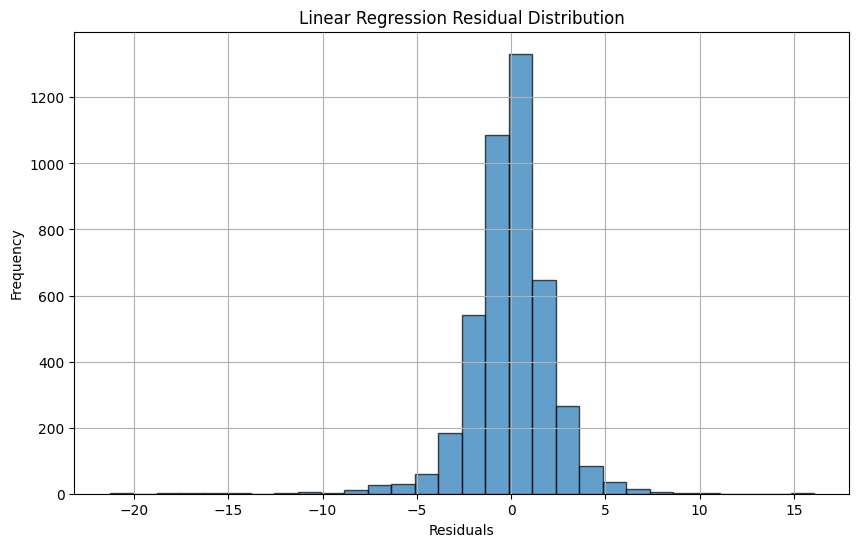

Polynomial regression RMSE:  [ 1148677.2 34969874.6 39438630.6 49406677.2 12678627.3]
Avg. RMSE:  27528497.39075594 



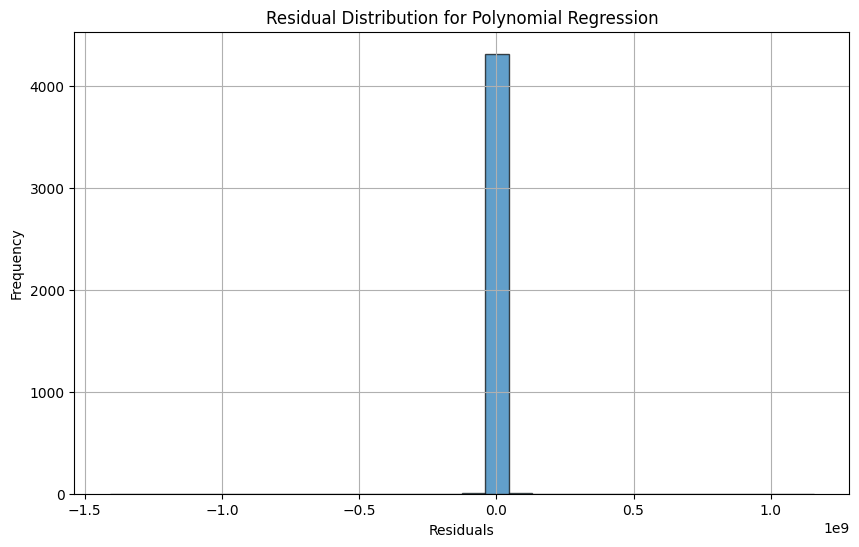

DecisionTreeRegressor rmse:  [2.5078296  2.6617638  2.42656065 2.36203083 2.6079747 ]
Avg. rmse:  2.5132319162731673 



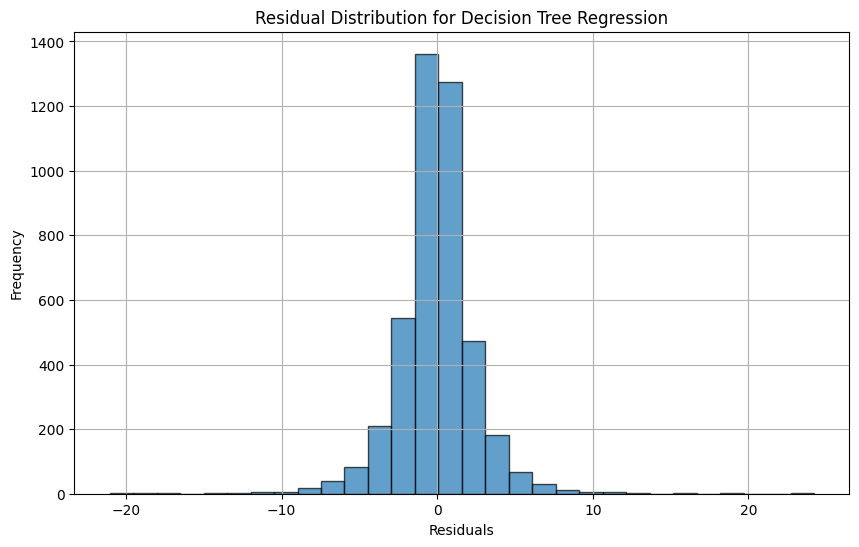

RandomForestRegressor rmse:  [2.08232262 2.13056756 1.99793793 2.13334077 2.10532096]
Avg. rmse:  2.089897968856035 



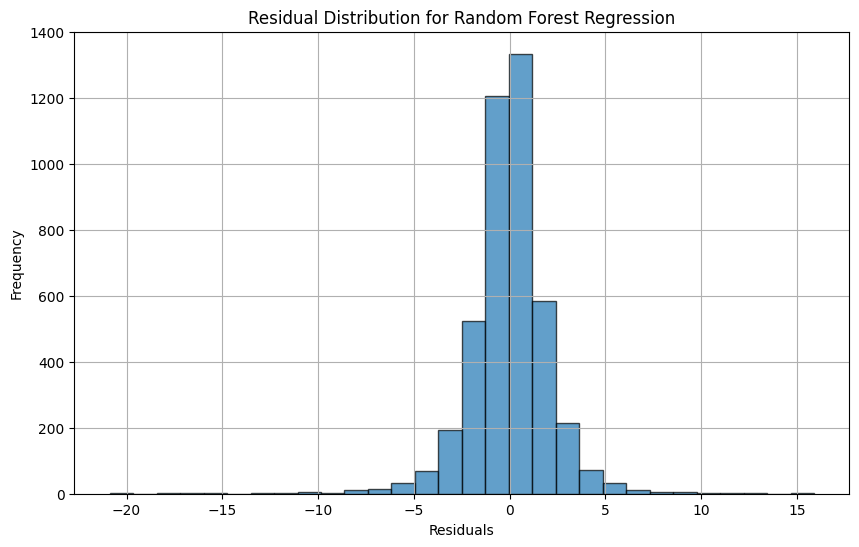

LightGBM rmse:  [1.81773454 1.90176157 1.85917579 1.8763239  1.79216157]
Avg. rmse:  1.8494314734488586 



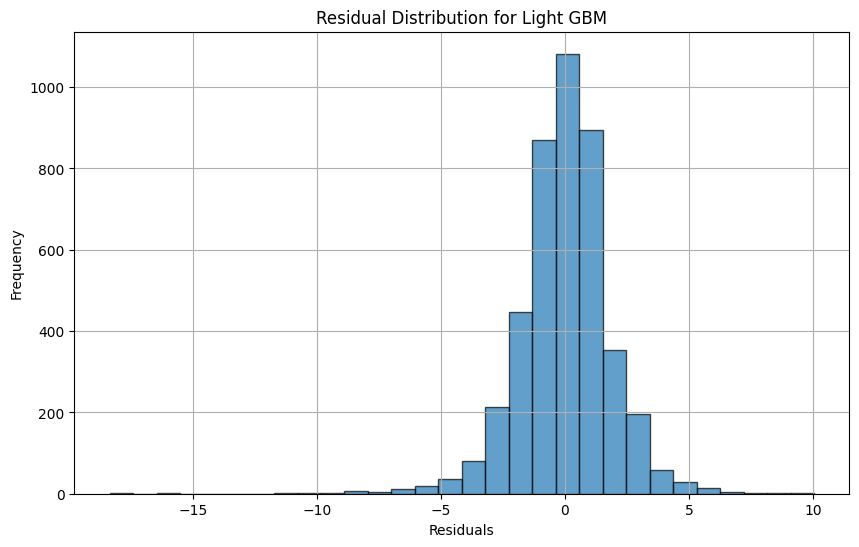

XGBoost rmse:  [1.90663548 1.90350755 1.83598362 1.93574091 1.92823636]
Avg. rmse:  1.9020207854539897 



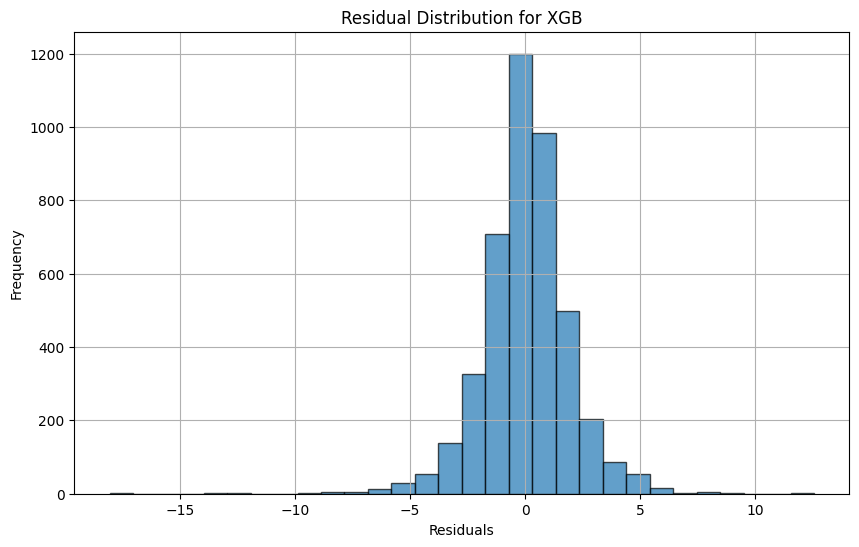

KNeighbor rmse:  [3.10646769 3.2435282  2.88967628 2.91979624 2.9623055 ]
Avg. rmse:  3.024354781668706 



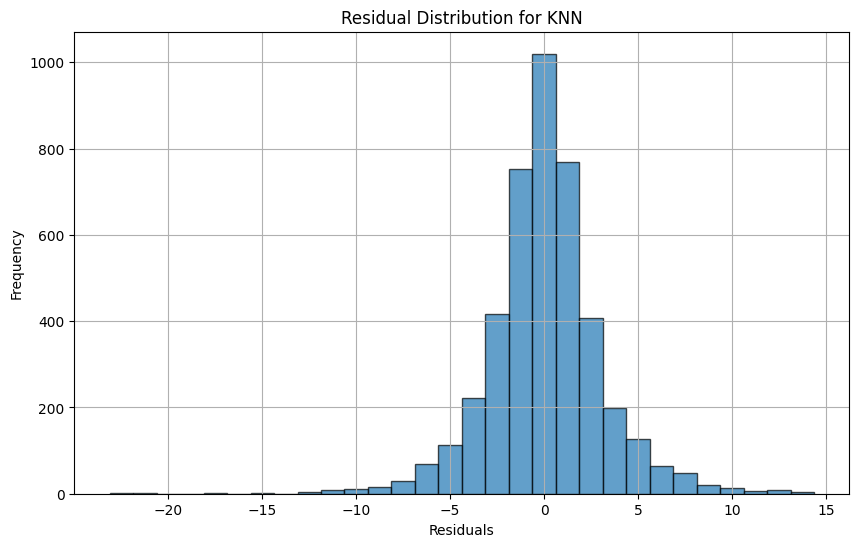

SVR rmse:  [4.68088942 4.91051778 4.48229548 4.77197337 4.06015747]
Avg. rmse:  4.581166705055609 



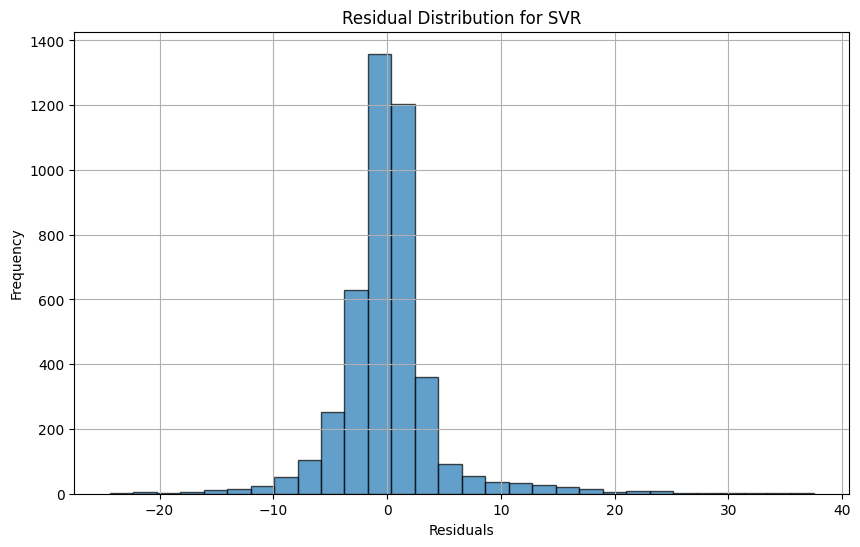

Choose: Random Forest, Polynomial Regression.


In [455]:
print('\n____________ K-fold cross validation ____________')
cv = KFold(n_splits=5,shuffle=True,random_state=37) # cv data generator

run_new_evaluation = 1
if run_new_evaluation:
    #Evaluate LinearRegression
    model_name = "LinearRegression"
    model = LinearRegression()
    nmse_scores = cross_val_score(model, X_train, y_train,cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores,'saved_objects/' + model_name + '_rmse.pkl')
    print("LinearRegression rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    # Step 2: Predict using cross-validation
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)
    # Step 3: Calculate residuals
    residuals = y_train - y_train_pred
    # Step 4: Plot the residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Linear Regression Residual Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    

    model = Pipeline([
        ('poly_features', PolynomialFeatures(degree=degree)),
        ('lin_reg', LinearRegression())
    ])

    # Perform cross-validation and evaluate
    nmse_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)

    # Save the RMSE scores
    model_name = "PolynomialRegression"
    joblib.dump(rmse_scores, 'saved_objects/' + model_name + '_rmse.pkl')

    print("Polynomial regression RMSE: ", rmse_scores.round(decimals=1))
    print("Avg. RMSE: ", np.mean(rmse_scores), '\n')

    # Step 2: Perform cross-validation predictions
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)

    # Step 3: Calculate residuals
    residuals = y_train - y_train_pred

    # Step 4: Plot the residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Residual Distribution for Polynomial Regression')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    model_name = "DecisionTreeRegressor" 
    model = DecisionTreeRegressor()
    nmse_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores,'saved_objects/' + model_name + '_rmse.pkl')
    print("DecisionTreeRegressor rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')


    # Step 2: Perform cross-validation predictions
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)

    # Step 3: Calculate residuals
    residuals = y_train - y_train_pred

    # Step 4: Plot the residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Residual Distribution for Decision Tree Regression')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    # Evaluate RandomForestRegressor
    model_name = "RandomForestRegressor" 
    model = RandomForestRegressor(n_estimators = 5)
    nmse_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores,'saved_objects/' + model_name + '_rmse.pkl')
    print("RandomForestRegressor rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    # Step 2: Perform cross-validation predictions
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)

    # Step 3: Calculate residuals
    residuals = y_train - y_train_pred

    # Step 4: Plot the residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Residual Distribution for Random Forest Regression')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    #Evaluate LGBM
    model_name = "LightGBM"
    model = lgb.LGBMRegressor(verbose = -1)
    nmse_scores = cross_val_score(model, X_train, y_train, cv = cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores, 'saved_objects/' + model_name + '_rmse.pkl')
    print("LightGBM rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    # Step 2: Perform cross-validation predictions
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)

    # Step 3: Calculate residuals
    residuals = y_train - y_train_pred

    # Step 4: Plot the residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Residual Distribution for Light GBM')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    #Evaluate XGB BoostRegressor
    model_name = "XGBoostRegressor"
    model = XGBRegressor()
    nmse_scores = cross_val_score(model, X_train, y_train, cv = cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores, 'saved_objects/' + model_name + '_rmse.pkl')
    print("XGBoost rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    # Step 2: Perform cross-validation predictions
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)

    # Step 3: Calculate residuals
    residuals = y_train - y_train_pred

    # Step 4: Plot the residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Residual Distribution for XGB')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    #Evaluate K nearest Neighbor
    model_name = "KNeighbor"
    model = KNeighborsRegressor(n_neighbors=5)
    nmse_scores = cross_val_score(model, X_train, y_train, cv = cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores, 'saved_objects/' + model_name + '_rmse.pkl')
    print("KNeighbor rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    # Step 2: Perform cross-validation predictions
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)

    # Step 3: Calculate residuals
    residuals = y_train - y_train_pred

    # Step 4: Plot the residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Residual Distribution for KNN')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    #Evaluate SVR M
    model_name = "SVR_model"
    model = SVR(kernel='rbf')
    nmse_scores = cross_val_score(model, X_train, y_train, cv = cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores, 'saved_objects/' + model_name + '_rmse.pkl')
    print("SVR rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    # Step 2: Perform cross-validation predictions
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)

    # Step 3: Calculate residuals
    residuals = y_train - y_train_pred

    # Step 4: Plot the residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Residual Distribution for SVR')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

else:
    #Load LinearRegression
    model_name = "LinearRegression" 
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("\nLinearRegression rmse: ", rmse_scores.round(decimals=1))
    print("Avg. rmse: ", mean(rmse_scores),'\n')
    
    #Load PolynomialRegression:
    model_name = "PolinomialRegression" 
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("Polinomial regression rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')
    
    #Load DecisionTreeRegressor
    model_name = "DecisionTreeRegressor" 
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("DecisionTreeRegressor rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')
    
    #Load RandomForestRegressor
    model_name = "RandomForestRegressor" 
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("RandomForestRegressor rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    #Load LightGBM
    model_name = "LightGBM"
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("LightGBM rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    #Load XGB
    model_name = "XGBoostRegressor"
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("XGBoost rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    #Load KNeighbor"
    model_name = "KNeighbor"
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("KNeighbor rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    #Load "SVR_model"
    model_name = "SVR_model"
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("SVR rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

print("Choose: Random Forest, Polynomial Regression.")

# **STEP 9: TRAIN AND FINE-TUNING MODEL**

In [458]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold
from lightgbm import LGBMRegressor
import joblib

print('\n____________ Fine-tune models ____________')

# Function to print results of grid search
def print_search_result(grid_search, model_name=""):
    print("\n====== Fine-tune " + model_name +" ======")
    print('Best hyperparameter combination: ',grid_search.best_params_)
    print('Best rmse: ', np.sqrt(-grid_search.best_score_)) 
    print('Performance of hyperparameter combinations:')
    cv_results = grid_search.cv_results_
    for (mean_score, params) in zip(cv_results["mean_test_score"], cv_results["params"]):
        print('rmse =', np.sqrt(-mean_score), params)

cv = KFold(n_splits=5, shuffle=True, random_state=37)

run_new_search = 1
if run_new_search:
    # Define a parameter grid for LightGBM
    # Defines a grid of hyperparameters to search over. 
    # A grid search algorithm will try all possible combinations of these parameters to find the optimal set for the LightGBM model.
    param_grid = {
        'n_estimators': [100, 200], #Number of boosting iterations (trees) to be built.
        'max_depth': [3, 5, 7], # Maximum depth of each tree.
        'learning_rate': [0.01, 0.1], # Step size shrinkage used to prevent overfitting
        'subsample': [0.8, 1.0], # Fraction of samples used for training each tree
        'colsample_bytree': [0.8, 1.0],  # Fraction of features used for training each tree
        'reg_alpha': [0, 0.1],  #L1 regularization term on weights
        'reg_lambda': [0, 0.1]  # L2 regularization term on weights
    }
    
    # Set up and run grid search
    lgb_model = LGBMRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, verbose=0)
    grid_search.fit(X_train, y_train)

    # Save grid search results
    joblib.dump(grid_search, 'saved_objects/LGBMRegressor_gridsearch.pkl')

    # Print search results
    print_search_result(grid_search, "LGBMRegressor")

    # Get best model from grid search
    best_model = grid_search.best_estimator_

    # Make predictions on training data
    y_train_pred = best_model.predict(X_train)

else:
    # Load previously saved grid search results
    grid_search = joblib.load('saved_objects/LGBMRegressor_gridsearch.pkl')
    print_search_result(grid_search, model_name="LGBMRegressor")
    
    # Get best model from grid search
    best_model = grid_search.best_estimator_
    
    # Make predictions on training data
    y_train_pred = best_model.predict(X_train)



____________ Fine-tune models ____________

====== Fine-tune LGBMRegressor ======
Best hyperparameter combination:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
Best rmse:  1.829897824803773
Performance of hyperparameter combinations:
rmse = 11.78712994541007 {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.8}
rmse = 11.78712994541007 {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1.0}
rmse = 11.792224180635236 {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.8}
rmse = 11.792224180635236 {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 1.0}
rmse = 11.78746

STEP 7:


____________ ANALYZE AND TEST SOLUTION ____________
SOLUTION:  LGBMRegressor(max_depth=7, n_estimators=200, random_state=42, reg_alpha=0.1,
              reg_lambda=0.1, subsample=0.8)
Model successfully saved as SOLUTION_model.pkl

Features and importance scores:
ATR: 385.0000
ADX: 304.0000
MA_200: 284.0000
Bull_Power: 271.0000
BB_Width: 269.0000
Stoch_Osc: 253.0000
Vortex_Plus: 252.0000
AO: 243.0000
Vortex_Minus: 243.0000
CCI: 240.0000
BOP: 227.0000
Low: 224.0000
BB_Low: 195.0000
MACD: 191.0000
High: 190.0000
Aroon_Down: 188.0000
BB_High: 176.0000
RSI: 174.0000
MA_50: 173.0000
Bear_Power: 170.0000
MA_10: 152.0000
Aroon_Up: 149.0000
Adj Close: 113.0000
Open: 74.0000
Volume: 0.0000
Volume_24h: 0.0000
ADL: 0.0000
Chaikin_Osc: 0.0000


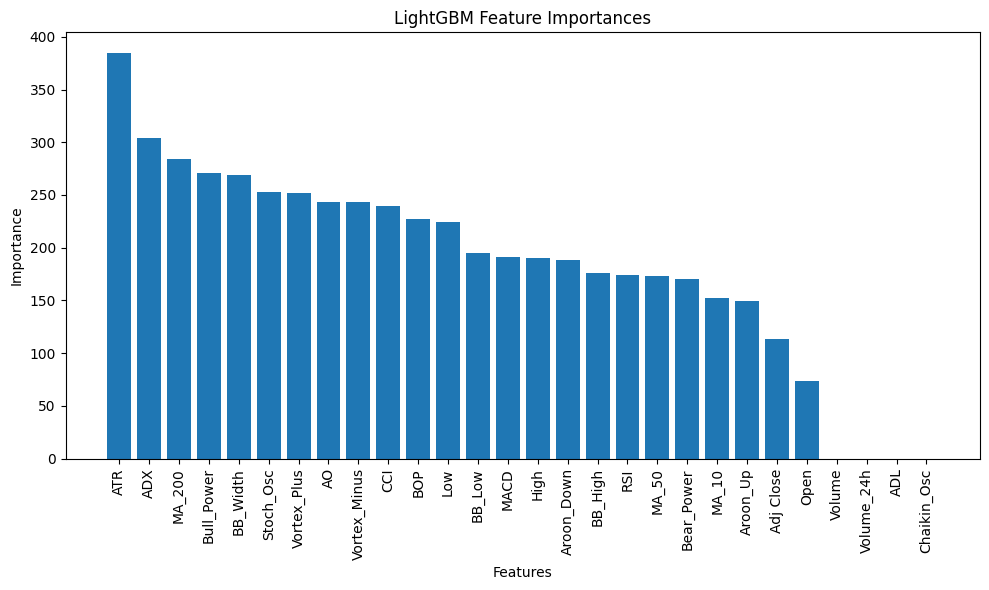


Performance on test data:
R2 score (on test data, best=1): 0.996745280711465
Root Mean Square Error:  1.7860920280013335

Test data: 
        Open      High       Low  Adj Close  Volume     MA_10     MA_50  \
0  0.961117  0.940850  0.928407   0.918725     0.0  0.992789  1.026533   
1 -0.981614 -0.981647 -0.993266  -0.976800     0.0 -1.011917 -1.046176   
2 -0.738224 -0.751803 -0.769015  -0.737516     0.0 -0.739132 -0.746589   
3 -1.067496 -1.052173 -1.046280  -1.065806     0.0 -1.094278 -1.150629   
4  1.449057  1.475342  1.444640   1.414205     0.0  1.522755  1.881164   
5  0.860659  0.850160  0.876848   0.860698     0.0  0.910935  0.750777   
6  1.218632  1.213306  1.230901   1.218366     0.0  1.276203  1.155047   
7  0.798578  0.845336  0.827489   0.862310     0.0  0.890160  1.009041   
8 -1.129835 -1.117296 -1.119963  -1.128539     0.0 -1.139229 -1.087543   

     MA_200       RSI      MACD  ...       ATR        AO       BOP  \
0  1.087169 -1.467788 -0.616632  ... -0.346624 -0.762

In [460]:
search = joblib.load('saved_objects/LGBMRegressor_gridsearch.pkl')
best_model = search.best_estimator_
print('\n____________ ANALYZE AND TEST SOLUTION ____________')
print('SOLUTION: ' , best_model)
store_model(best_model, model_name="SOLUTION")   

if type(best_model).__name__ == "LGBMRegressor":
    # Get feature importances
    feature_importances = best_model.feature_importances_
    
    # Get feature names (assuming X_train.columns contains your feature names)
    feature_names = X_train.columns.tolist()
    
    # Create a list of tuples with feature names and their importance scores
    feature_importance_pairs = list(zip(feature_names, feature_importances))
    
    # Sort the pairs by importance score in descending order
    sorted_importances = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)
    
    print('\nFeatures and importance scores:')
    for name, importance in sorted_importances:
        print(f"{name}: {importance:.4f}")

    # Optionally, you can create a bar plot of feature importances
    plt.figure(figsize=(10, 6))
    plt.bar([x[0] for x in sorted_importances], [x[1] for x in sorted_importances])
    plt.xticks(rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('LightGBM Feature Importances')
    plt.tight_layout()
    plt.show()

#%% 7.3 Run on test data
try:
    num_pipeline = joblib.load(r'models/num_pipeline.pkl')
except FileNotFoundError:
    print("Error: num_pipeline.pkl file not found. Make sure you have saved the pipeline.")
    # Nếu không tìm thấy file, bạn có thể cần phải tạo và lưu pipeline trước

processed_test_set = num_pipeline.transform(test_set)
# 7.3.1 Compute R2 score and root mean squared error
r2score, rmse = r2score_and_rmse(best_model, processed_test_set, y_test)
print('\nPerformance on test data:')
print('R2 score (on test data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# 7.3.2 Predict labels for some test instances
print("\nTest data: \n", X_test.iloc[0:9])
print("\nPredictions: ", best_model.predict(processed_test_set[0:9]).round(decimals=1))
print("Labels:      ", list(y_test[0:9]),'\n')
print("\nProcessed: \n", processed_test_set)

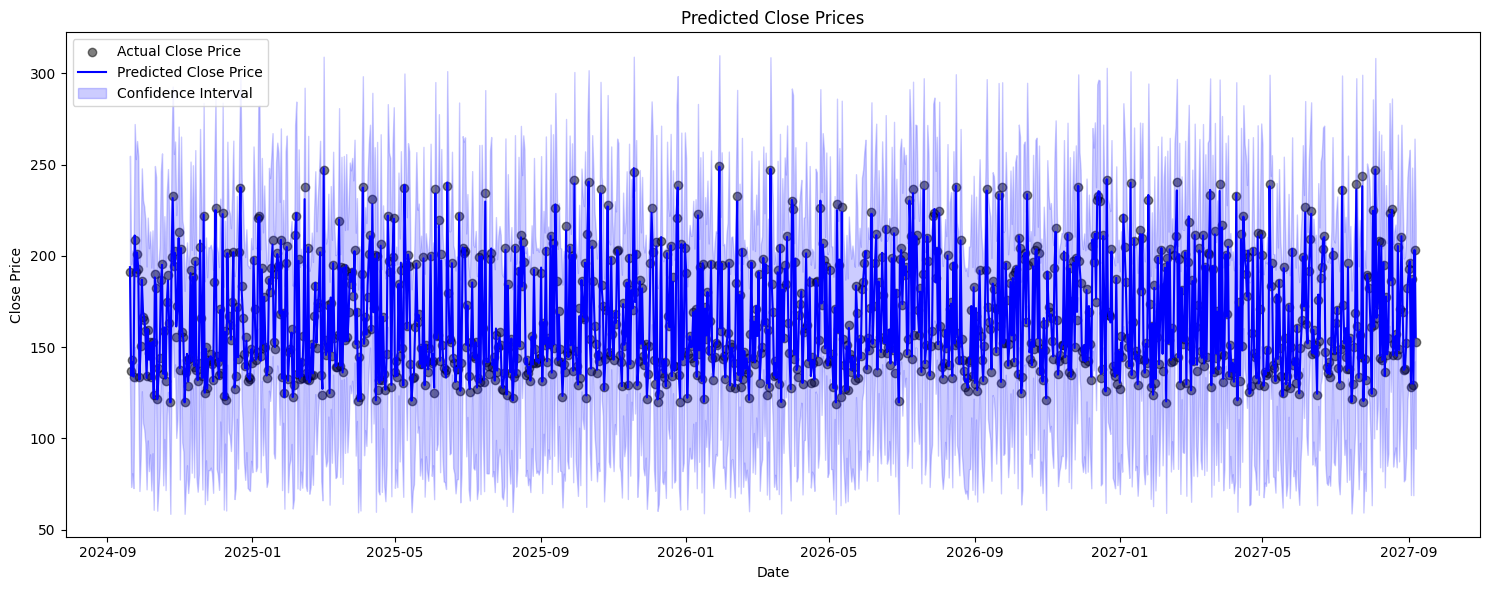

In [483]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming predictions, labels, dates, ci_lower, and ci_upper are already defined
# Example predictions and labels for demonstration purposes
predictions = best_model.predict(processed_test_set).round(decimals=1)
labels = list(y_test)

# Example date range for the test instances
dates = pd.date_range(start='2024-09-20', periods=len(predictions))

# Simulating confidence intervals
ci_lower = predictions - 1.96 * np.std(predictions)  # Example lower bound
ci_upper = predictions + 1.96 * np.std(predictions)  # Example upper bound

# Create a DataFrame
results_df = pd.DataFrame({
    'Date': dates,
    'Predicted Close Price': predictions.flatten(),  # Flatten in case of multi-dimensional output
    'Actual Close Price': labels,
    'CI Lower Bound': ci_lower.flatten(),
    'CI Upper Bound': ci_upper.flatten()
})

# Export to CSV
results_df.to_csv('predictions_and_labels.csv', index=False)

# Plotting (unchanged)
plt.figure(figsize=(15, 6))
plt.scatter(dates, labels, color='black', alpha=0.5, label='Actual Close Price')
plt.plot(dates, predictions, color='blue', label='Predicted Close Price')
plt.fill_between(dates, ci_lower, ci_upper, color='blue', alpha=0.2, label='Confidence Interval')

plt.title('Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()
